# Using a CFSv2 forecast

__[CFSv2](https://data.planetos.com/datasets/ncep_cfsv2)__  is a seasonal forecast system, used for analysing past climate and also making seasonal, up to 9-month, forecasts. Here we give a brief example on how to use Planet OS API to merge 9-month forecasts started at different initial times, into a single ensemble forecast.

Ensemble forecasting is a traditional technique in medium range (up to 10 days) weather forecasts, seasonal forecasts and climate modelling. By changing initial conditions or model parameters, a range of forecasts is created, which differ from each other slightly, due to the chaotic nature of fluid dynamics (which weather modelling is a subset of). For weather forecasting, the ensemble is usually created by small changes in initial conditions, but for seasonal forecast, it is much easier to just take real initial conditions every 6-hours. Here we are going to show, first how to merge the different dates into a single plot with the help of python pandas library, and in addition we show that even 6-hour changes in initial conditions can lead to large variability in long range forecasts. 

In this example we look into 2 m temperture for upcoming winter. We are also adding climatological averages from __[CFS Reanalysis Climatologies](https://data.planetos.com/datasets/ncep_cfsr_climatologies)__ to the plot for better overview. 

If you have more interest in Planet OS API, please refer to our official __[documentation](data.planetos.com/datasets)__.

Please also note that the `API_client` python routine, used in this notebook, is still experimental and will change in the future, so take it just as a guidance using the API, and not as an official tool.

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import matplotlib.dates as mdates
from API_client.python.datahub import datahub_main
from API_client.python.lib.dataset import dataset
from API_client.python.lib.variables import variables
import matplotlib
import warnings
warnings.filterwarnings("ignore")
matplotlib.rcParams['font.family'] = 'Avenir Lt Std'
print (matplotlib.__version__)

3.0.3


The API needs a file `APIKEY` with your API key in the work folder. We initialize a datahub and dataset objects.

In [2]:
apikey = open('APIKEY').readlines()[0].strip()
dh = datahub_main(apikey)
ds = dataset('ncep_cfsv2', dh, debug=False)
ds2 = dataset('ncep_cfsr_climatologies', dh, debug=False)

In [3]:
ds.vars = variables(ds.variables(), {'reftimes':ds.reftimes,'timesteps':ds.timesteps},ds)
ds2.vars = variables(ds2.variables(), {},ds2)

At the moment we are going to look into Tallinn, Innsbruck, Paris, Berlin and Lisbon temperature. In order to the automatic location selection to work, add your custom location to the `API_client.python.lib.predef_locations` file and after add your location into the list of locations here. 

In [4]:
locations = ['Tallinn','Innsbruck','Paris','Berlin','Lisbon']
for locat in locations:
    ds2.vars.TMAX_2maboveground.get_values_analysis(count=1000, location=locat)
    ds.vars.Temperature_height_above_ground.get_values(count=1000, location=locat, reftime='2019-10-20T00:00:00',
                                                            reftime_end='2019-11-02T18:00:00')

Here we clean the table just a bit and create time based index.

In [5]:
def clean_table(loc):
    ddd_clim = ds2.vars.TMAX_2maboveground.values[loc][['time','TMAX_2maboveground']]
    ddd_temp = ds.vars.Temperature_height_above_ground.values[loc][['reftime','time','Temperature_height_above_ground']]
    dd_temp=ddd_temp.set_index('time')
    
    return ddd_clim,dd_temp

Next, we resample the data to 1-month totals.

In [6]:
def resample_1month_totals(loc):
    reft_unique = ds.vars.Temperature_height_above_ground.values[loc]['reftime'].unique()
    nf_tmp = []
    for reft in reft_unique:
        abc = dd_temp[dd_temp.reftime==reft].resample('M').mean()
        abc['Temperature_height_above_ground'+'_'+reft.astype(str)] = \
             abc['Temperature_height_above_ground'] - 272.15
        del abc['Temperature_height_above_ground']
        nf_tmp.append(abc)
    nf2_tmp = pd.concat(nf_tmp,axis=1)
    return nf2_tmp

Give new indexes to climatology dataframe to have data ordered the same way as cfsv2 forecast.

In [7]:
def reindex_clim_convert_temp():
    i_new = 0
    ddd_clim_new_indxes = ddd_clim.copy()
    new_indexes = []
    converted_temp = []
    for i,clim_values in enumerate(ddd_clim['TMAX_2maboveground']):
        if i == 0:
            i_new = 12 - nf2_tmp.index[0].month + 2
        else:
            i_new = i_new + 1
            if i_new == 13:
                i_new = 1

        new_indexes.append(i_new)
        converted_temp.append(ddd_clim_new_indxes['TMAX_2maboveground'][i] -272.15)
    ddd_clim_new_indxes['new_index'] = new_indexes
    ddd_clim_new_indxes['tmp_c'] = converted_temp
    return ddd_clim_new_indxes

Finally, we are visualizing the monthly mean temperature for each different forecast, in a single plot. 

In [8]:
def make_image(loc):
    fig=plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    plt.ylim(np.min(np.min(nf2_tmp))-3,np.max(np.max(nf2_tmp))+3)
    plt.boxplot(nf2_tmp,medianprops=dict(color='#1B9AA0'))
    dates2 = [n.strftime('%b %Y') for n in nf2_tmp.index]
    plt.plot(np.arange(2, len(dates2)),ddd_clim_indexed.sort_values(by=['new_index'])['tmp_c'][1:-3],"*",color='#EC5840',linestyle='-')
    plt.xticks(np.arange(2, len(dates2)), dates2[1:-1], rotation='vertical')
    plt.grid(color='#C3C8CE',alpha=1)
    plt.ylabel('Monthly Temperature [C]')
    ttl = plt.title('Monthly Temperature in ' + loc,fontsize=15,fontweight='bold')
    ttl.set_position([.5, 1.05])
    fig.autofmt_xdate() 
    #plt.savefig('Monthly_mean_temp_cfsv2_forecast_{0}.png'.format(loc),dpi=300,bbox_inches='tight')
    plt.show()
    

Below we can find five location graphs. It's forecasted that November seems to be quite similar to climatological mean (red line) while December might be much warmer than usual. January again is pretty similar to the climatology. After January all the months are forecasted to be colder as average, specially April and May. 

Forecast for Innsbruck is intresting. It's forecasted that upcoming seven months will be colder as usual. For example, January mean temperature might be two degrees lower.

In the same time, Paris might face bit colder November, while December and January could be pretty average. After that, all the forecasted values are rather colder as climatology.

Berlin might get pretty average November. However, after that December could get much colder. January and February could be quite average. After that, temperatures might be colder as usual. 

Temperatures in Lisbon are forecasted to be bit colder in winter and spring. However, May is forecasted to quite average, while June forecast is way warmer as climatological mean. 

<IPython.core.display.Javascript object>


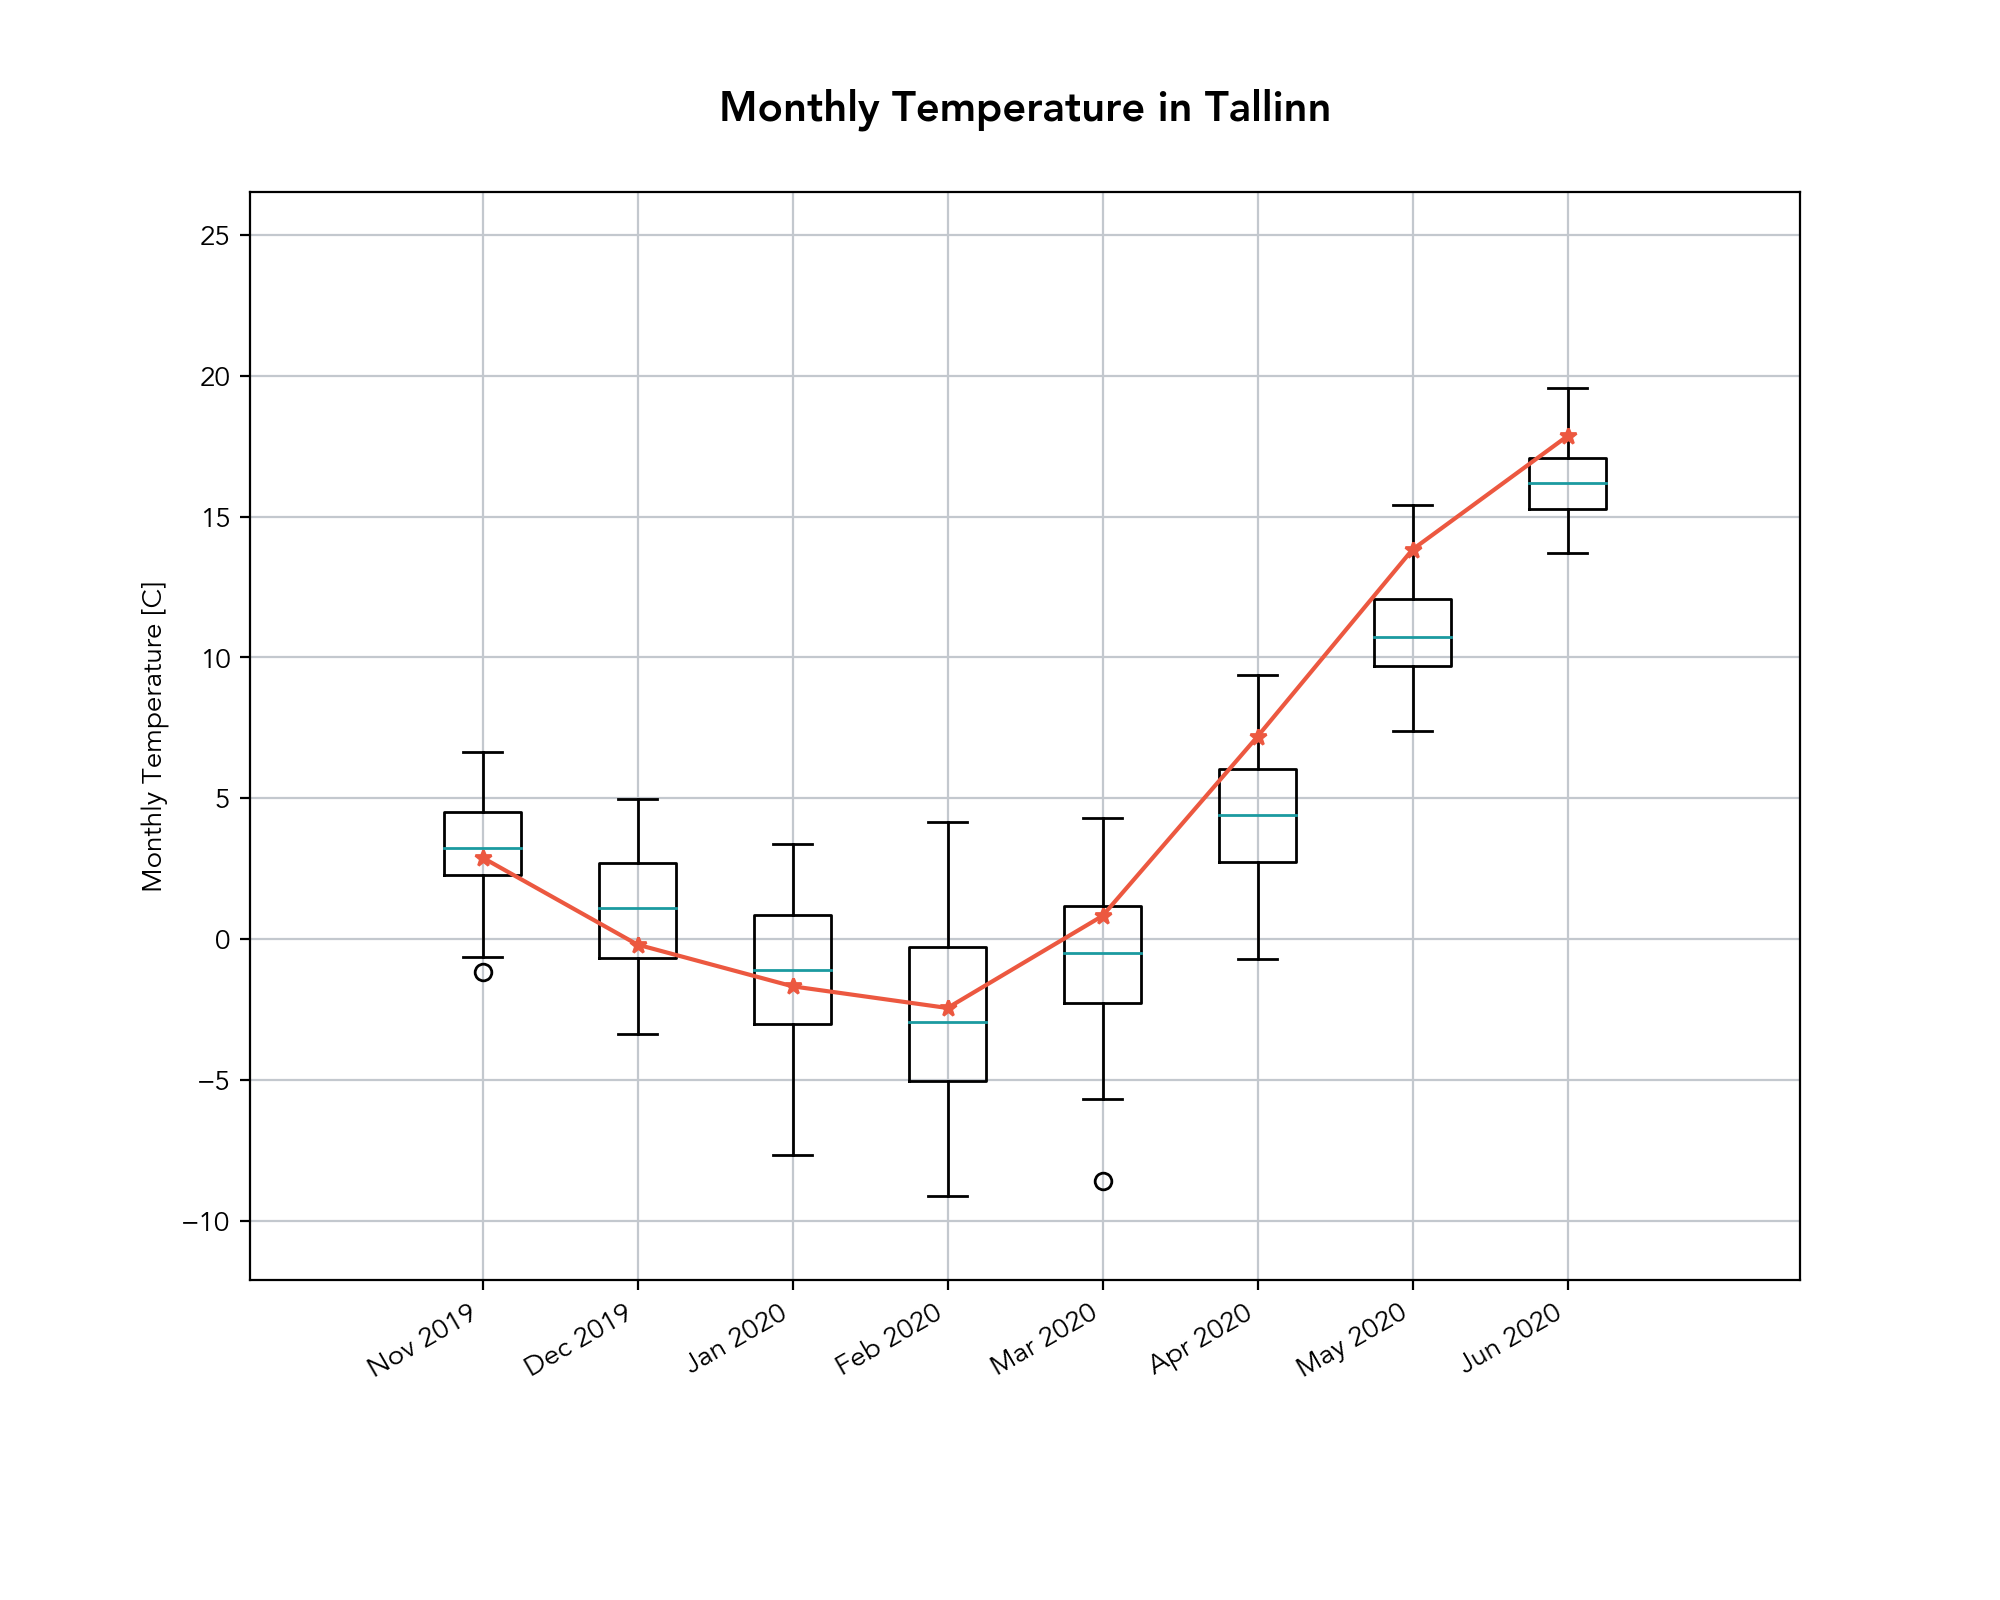

<IPython.core.display.Javascript object>


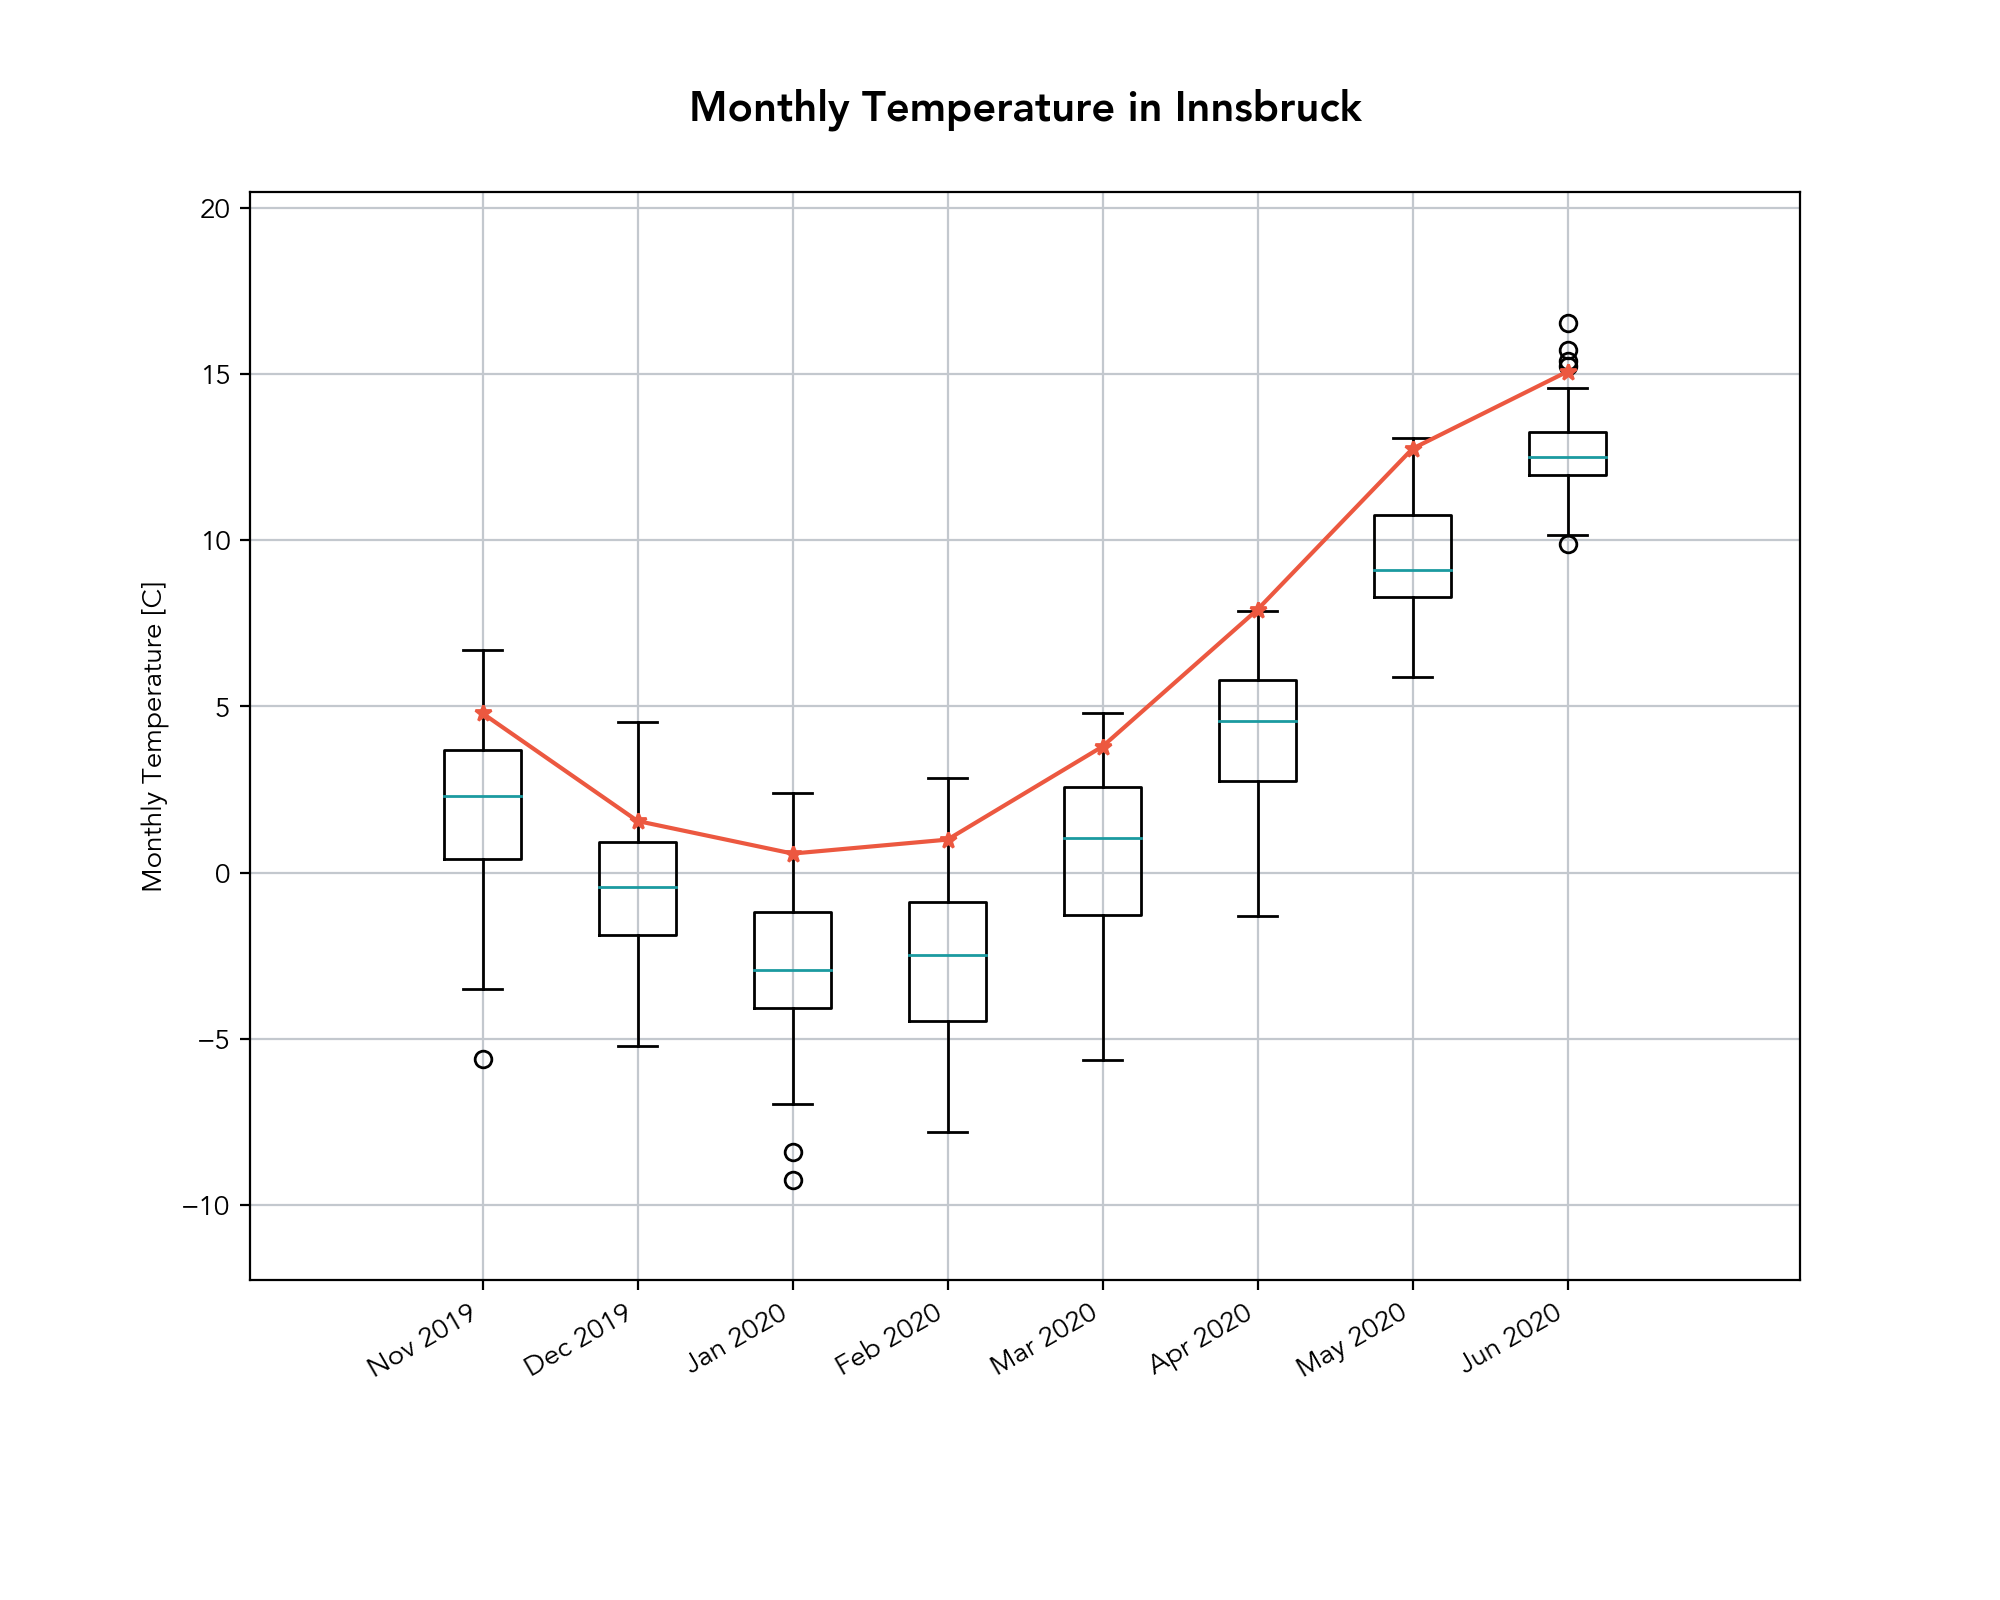

<IPython.core.display.Javascript object>


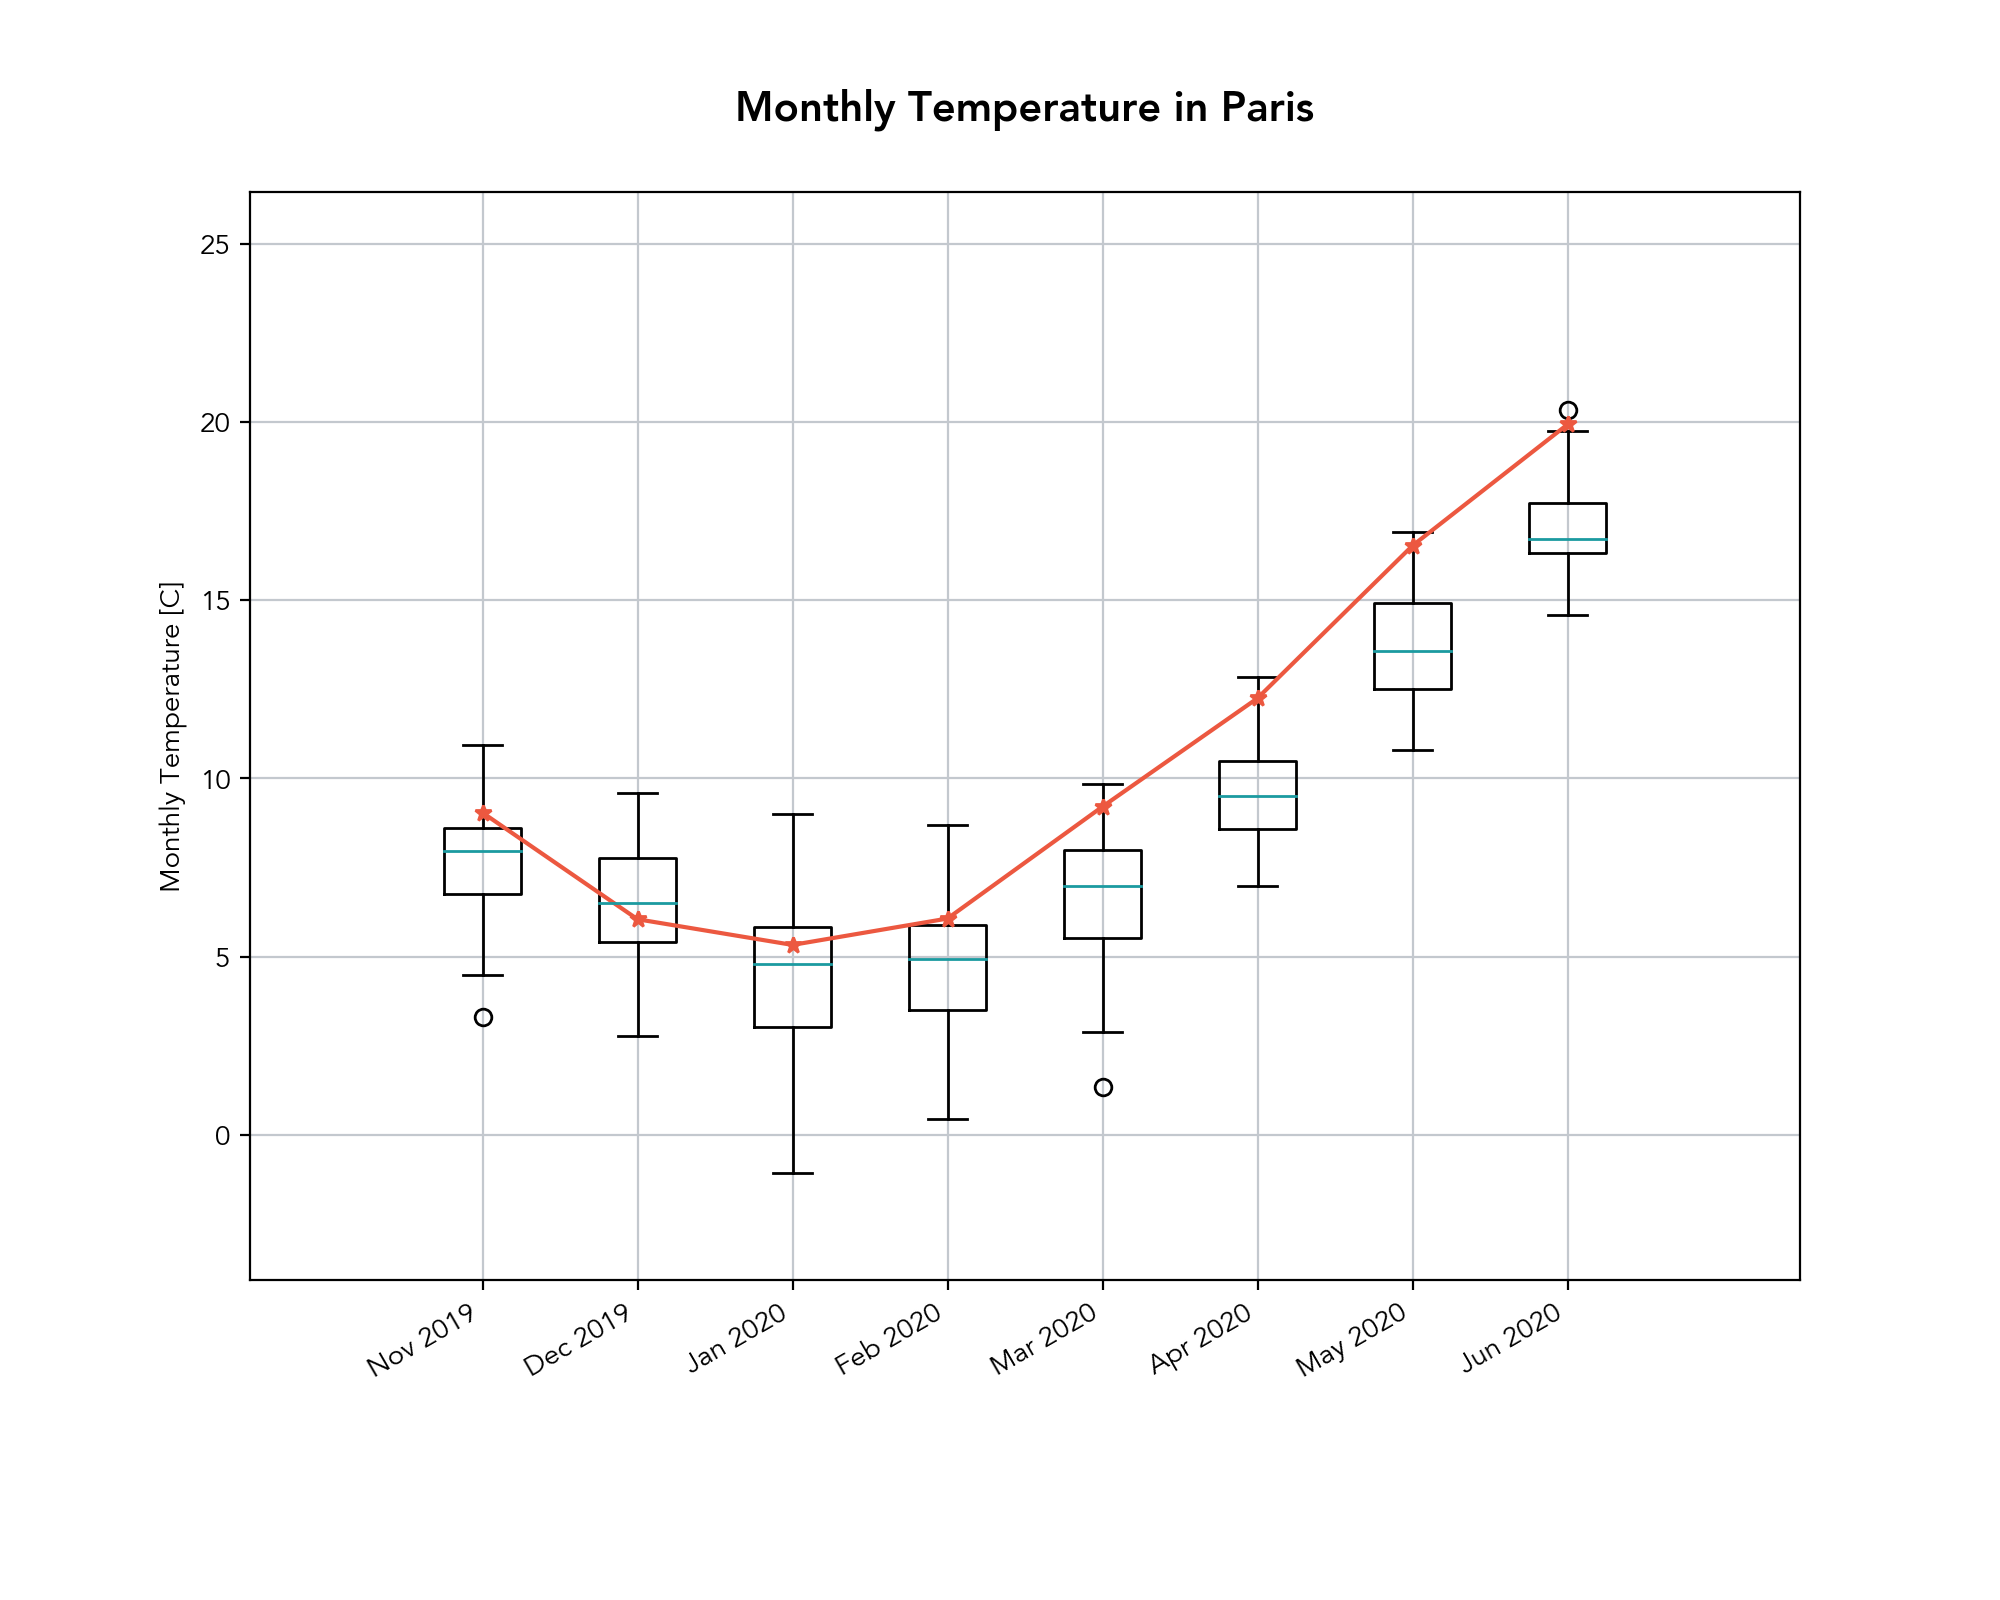

<IPython.core.display.Javascript object>


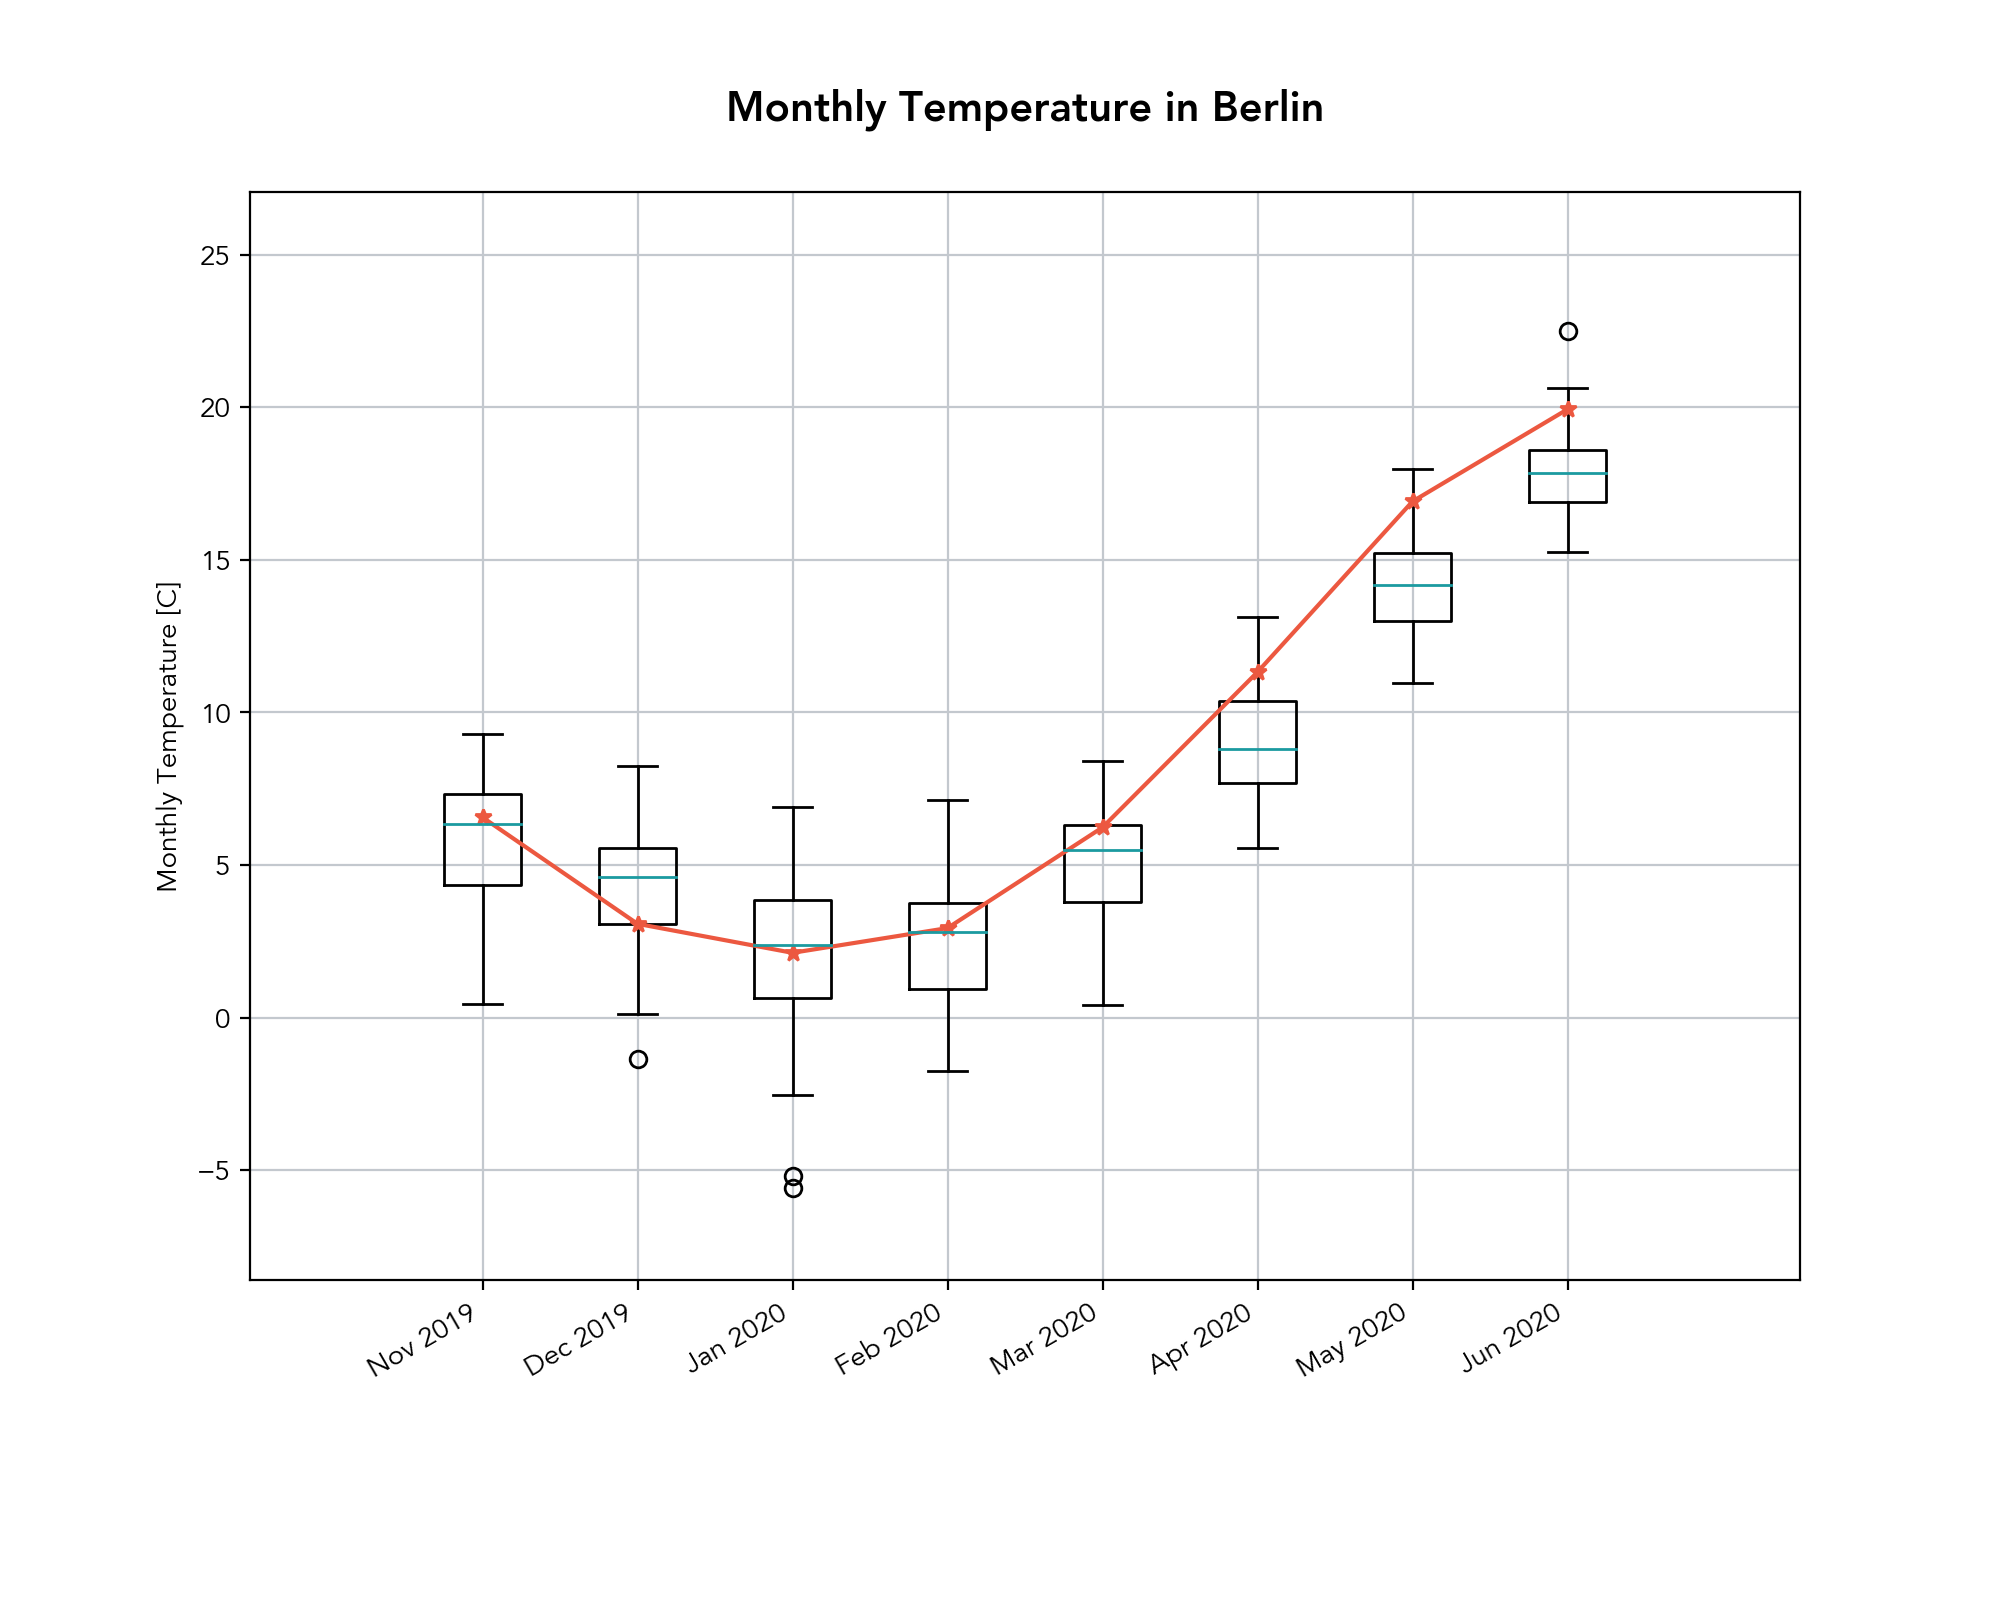

<IPython.core.display.Javascript object>


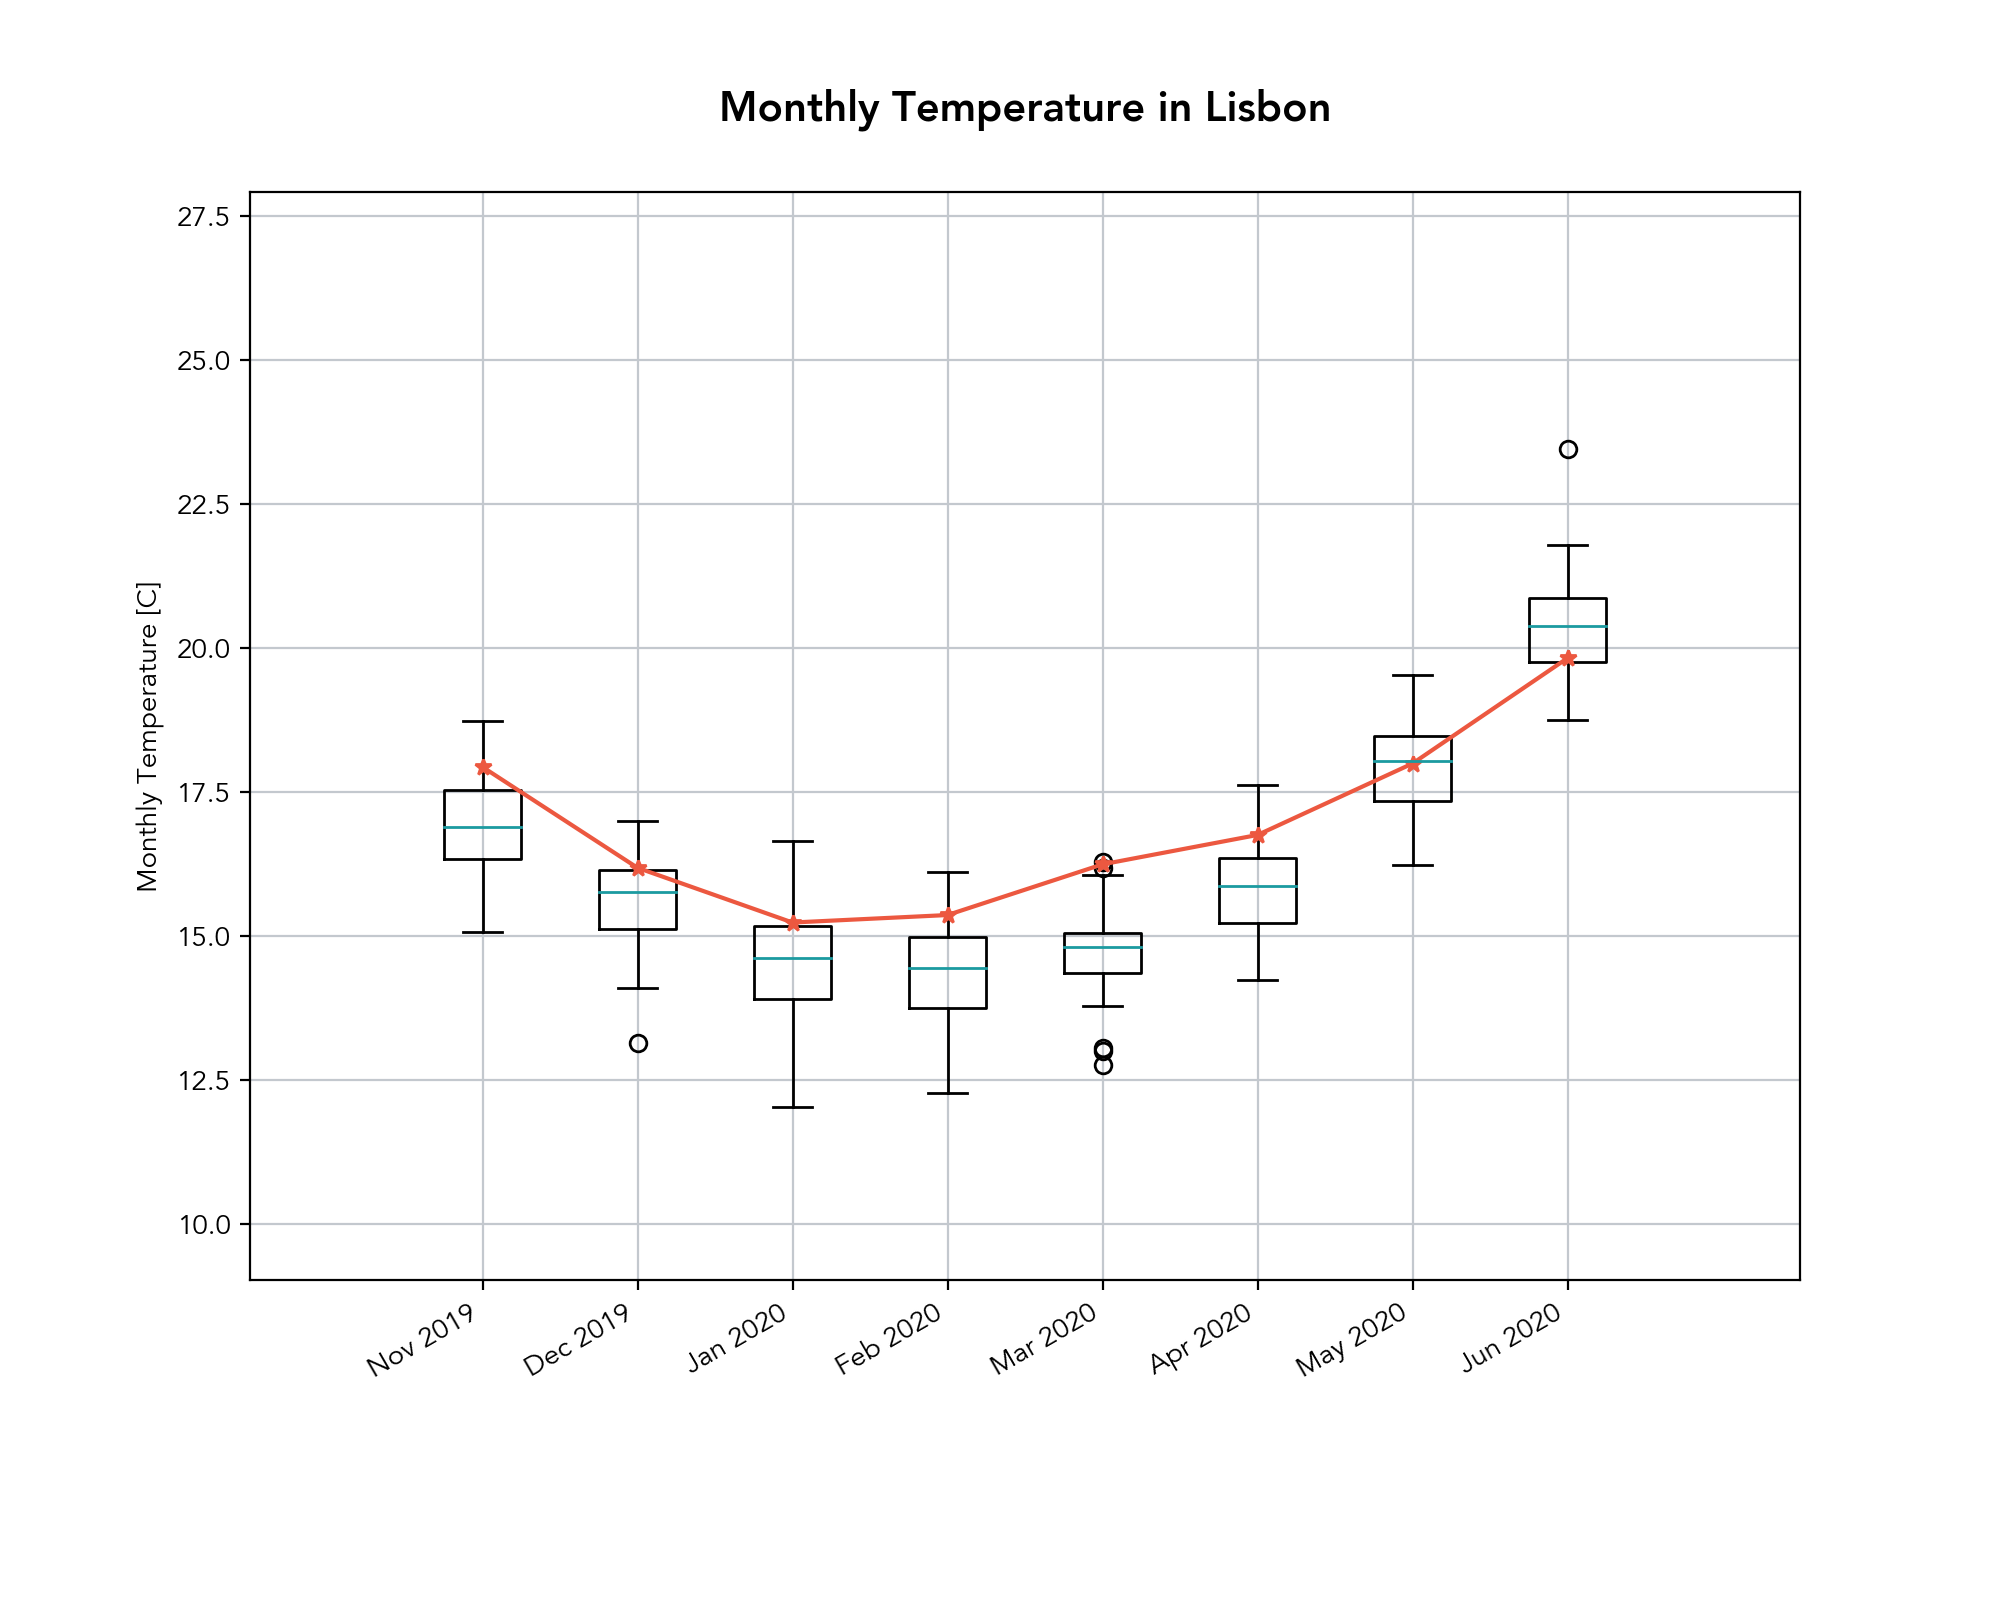

In [9]:
for locat in locations:
    ddd_clim,dd_temp = clean_table(locat)
    nf2_tmp = resample_1month_totals(locat)
    ddd_clim_indexed = reindex_clim_convert_temp()
    make_image(locat)
    

In conclusion, temprerature varies a lot over Europe. Every region has it's own pattern. Keep in mind that it's just a forecast and it might be totally different. However, let us know if it was right for your location. 